# 📊 Capstone Project: Bank Marketing Campaign Classification with AI Support
Proyek ini bertujuan untuk memprediksi apakah pelanggan akan berlangganan produk deposito berjangka berdasarkan data kampanye pemasaran bank. Selain itu, proyek ini juga mengeksplorasi bagaimana IBM Granite dapat digunakan untuk melakukan analisis data dan menghasilkan insight bisnis.

In [51]:
# Install library eksternal
!pip install langchain_community
!pip install replicate

In [52]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
from langchain_community.llms import Replicate
from google.colab import userdata

In [54]:
# Load dataset
df = pd.read_csv("dataset/bank-direct-marketing-campaigns.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [55]:
# EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [56]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [57]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


<Axes: title={'center': 'Distribusi Target'}, xlabel='y'>

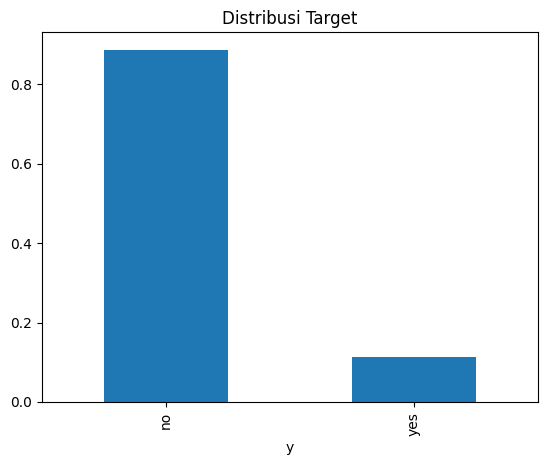

In [58]:
# Distribusi target
df['y'].value_counts(normalize=True).plot(kind='bar', title='Distribusi Target')

In [35]:
eda_prompt = f"""
Berikut ringkasan statistik data kampanye pemasaran bank:

{df.describe().to_string()}

Beberapa kolom kategori:
{df.select_dtypes(include='object').columns.tolist()}

Tolong bantu jelaskan pola-pola penting, outlier, dan insight awal dari data ini.
"""

response = llm.invoke(eda_prompt)
print(response)

Based on the provided summary statistics of the bank marketing campaign data, here are some key patterns, potential outliers, and initial insights:

1. **Age Distribution**: The mean age of the customers is 40.02 years, with a standard deviation of 10.42 years. The minimum age is 17, and the maximum age is 98, suggesting a broad range of customer ages. The 25th percentile (Q1) is 32, the median (Q2 or 50th percentile) is 38, and the 75th percentile (Q3) is 47. This indicates that the majority of customers fall between 32 and 47 years old.

2. **Campaign Participation**: The mean number of campaigns a customer has been exposed to is 2.57, with a maximum of 56 campaigns. This suggests some customers are highly targeted with marketing campaigns, while most have been exposed to fewer campaigns (mean < 3).

3. **Days Past Due (pdays)**: The mean number of days past due is 962.48, with a maximum of 999 (indicating no past due days for most customers). The median value is 999, which suggests 

In [59]:
# Encode fitur kategorikal
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop('y_yes', axis=1)
y = df_encoded['y_yes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Modeling dengan Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.97      0.94      7303
        True       0.54      0.29      0.38       935

    accuracy                           0.89      8238
   macro avg       0.73      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238



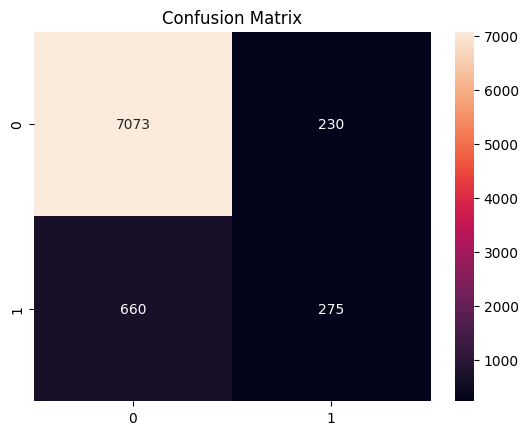

age: 0.1739
euribor3m: 0.1288
campaign: 0.0853
nr.employed: 0.0416
pdays: 0.0409


In [61]:
# Confusion matrix dan feature importance
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

feature_importance = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)[:5]
for name, score in feature_importance:
  print(f"{name}: {score:.4f}")

In [62]:
# Setup token dan model
api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

In [63]:
# Siapkan prompt
accuracy = model.score(X_test, y_test) * 100
top_features_text = "\n".join([f"- {feat}: {round(score, 4)}" for feat, score in feature_importance])
prompt = f"""
Berikut adalah ringkasan hasil klasifikasi kampanye pemasaran bank:
- Akurasi model: {round(accuracy, 2)}%
- Fitur yang paling berpengaruh:
{top_features_text}

Buatkan insight dan rekomendasi pemasaran berdasarkan hasil tersebut.
"""

response = llm.invoke(prompt)
print(response)

Based on the classification model results for the bank marketing campaign, here are some insights and marketing recommendations:

1. **High Accuracy**: The model's accuracy is 89.2%, indicating that it effectively predicts customer responses to the marketing campaign. This high accuracy can be leveraged to optimize campaign targeting and resource allocation.

2. **Influential Features**:

   - **Age (0.1739)**: Age has a relatively high impact on campaign response, suggesting that tailoring marketing strategies to different age groups might be beneficial. For instance, younger customers may prefer digital channels, while older customers might respond better to traditional methods like mail or phone calls.

   - **Euribor3m (0.1288)**: This feature represents the Euro Interbank Offered Rate (Euribor) for 3 months. It implies that economic factors, such as interest rates, significantly influence customers' decisions. During periods of low or high Euribor rates, adjust marketing messages 